# x2d-bsm

In [1]:
import sys
import os
from os.path import join
from datetime import datetime
import importlib
from pprint import pprint
import json
import numpy as np
import pandas as pd
import h5py
import skimage
from tqdm import trange
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import patches
import proplot as pplt

sys.path.append('..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt
from tools import utils

In [2]:
pplt.rc['grid'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['cmap.discrete'] = False

## Load data 

In [18]:
datadir = '/Diagnostics/Data/Measurements/xz4d/2022-07-01/'
filenames = os.listdir(datadir)
filenames

['220701194753-xz4d-phaseCalibration.h5',
 '220701200123-xz4d.h5',
 '220701194753-xz4d-background.h5',
 '220701194753-xz4d-screenResponse.h5',
 '220701200440-xz4d.h5',
 '220701202256-xz4d.h5']

In [19]:
filename = '220701202256-xz4d.h5'
file = h5py.File(join(datadir, filename), 'r')
data = file['scandata']
pprint(data.dtype.fields)

mappingproxy({'I_CurrentRb': (dtype('<f8'), 4560),
              'I_CurrentSet': (dtype('<f8'), 4568),
              'bcm04': (dtype('<f8'), 16),
              'cam08_Integral': (dtype('<f8'), 4536),
              'cam08_ProfileX': (dtype(('<f4', (612,))), 2080),
              'cam08_ProfileY': (dtype(('<f4', (512,))), 32),
              'cam08_Saturation': (dtype('<f8'), 4528),
              'iteration': (dtype('int64'), 8),
              'phase_Readback': (dtype('<f8'), 4576),
              'phase_Set': (dtype('<f8'), 4584),
              'slowQ': (dtype('<f8'), 24),
              'steerI_Readback': (dtype('<f8'), 4600),
              'steerI_Set': (dtype('<f8'), 4592),
              'timestamp': (dtype('<f8'), 0),
              'x_PositionSync': (dtype('<f8'), 4552),
              'xp_PositionSync': (dtype('<f8'), 4544)})


In [23]:
if 'config' in file:
    config = file['config']
    print(f"'config', {type(config)}")
    for key in config:
        print(f"  '{key}', {type(config[key])}")
        for name in config[key].dtype.names:
            print(f'    {name}: {config[key][name]}')
    # Make dictionary of metadata
    if 'metadata' in config:
        metadata = dict()
        for name in config['metadata'].dtype.names:
            metadata[name] = config['metadata'][name]
else:
    # Older measurement; metadata is in json file.
    metadata_filename = filename + '-metadata.json'
    if metadata_filename in os.listdir(datadir):
        metadata = json.load(open(join(datadir, metadata_filename), 'r'))
        _metadata = dict()
        for _dict in metadata.values():
            for key, value in _dict.items():
                _metadata[key] = value
        metadata = _metadata
        pprint(metadata)

'config', <class 'h5py._hl.group.Group'>
  'environment', <class 'h5py._hl.dataset.Dataset'>
    timestamp: [1.65672138e+09]
    user: [b'k0r']
    host: [b'btf-diag-app1.ics.sns.gov']
    cmd_line: [b'scan4d/xz4d.py']
    work_dir: [b'/home/k0r/btf-scripts']


In [24]:
if 'log' in file:
    log = file['log']
    print(f"'log', {type(log)}")
    for item in log.dtype.fields.items():
        print('  ', item)

    print('\nErrors and warnings:')
    for i in range(log.size):
        if not(log[i, 'level'] == 'INFO'.encode('utf')):
            timestr = datetime.fromtimestamp(log[i, 'timestamp']).strftime("%m/%d/%Y, %H:%M:%S")
            print(f"{timestr} {log[i, 'message']}")

'log', <class 'h5py._hl.dataset.Dataset'>
   ('timestamp', (dtype('<f8'), 0))
   ('level', (dtype('S15'), 8))
   ('source', (dtype('S20'), 23))
   ('message', (dtype('S512'), 43))

Errors and warnings:


In [25]:
data = file['scandata']

print(f"'scandata', {type(data)}")
for item in data.dtype.fields.items():
    print('  ', item)
print(f"nbytes = {data.nbytes:.3e}")

'scandata', <class 'h5py._hl.dataset.Dataset'>
   ('timestamp', (dtype('<f8'), 0))
   ('iteration', (dtype('int64'), 8))
   ('bcm04', (dtype('<f8'), 16))
   ('slowQ', (dtype('<f8'), 24))
   ('cam08_ProfileY', (dtype(('<f4', (512,))), 32))
   ('cam08_ProfileX', (dtype(('<f4', (612,))), 2080))
   ('cam08_Saturation', (dtype('<f8'), 4528))
   ('cam08_Integral', (dtype('<f8'), 4536))
   ('xp_PositionSync', (dtype('<f8'), 4544))
   ('x_PositionSync', (dtype('<f8'), 4552))
   ('I_CurrentRb', (dtype('<f8'), 4560))
   ('I_CurrentSet', (dtype('<f8'), 4568))
   ('phase_Readback', (dtype('<f8'), 4576))
   ('phase_Set', (dtype('<f8'), 4584))
   ('steerI_Set', (dtype('<f8'), 4592))
   ('steerI_Readback', (dtype('<f8'), 4600))
nbytes = 6.525e+06


In [57]:
acts = ['xp_PositionSync', 'x_PositionSync', 'phase_Set']

In [58]:
# fig, ax = pplt.subplots(figsize=(10, 2))
# for act in acts:
#     ax.plot(data[act])

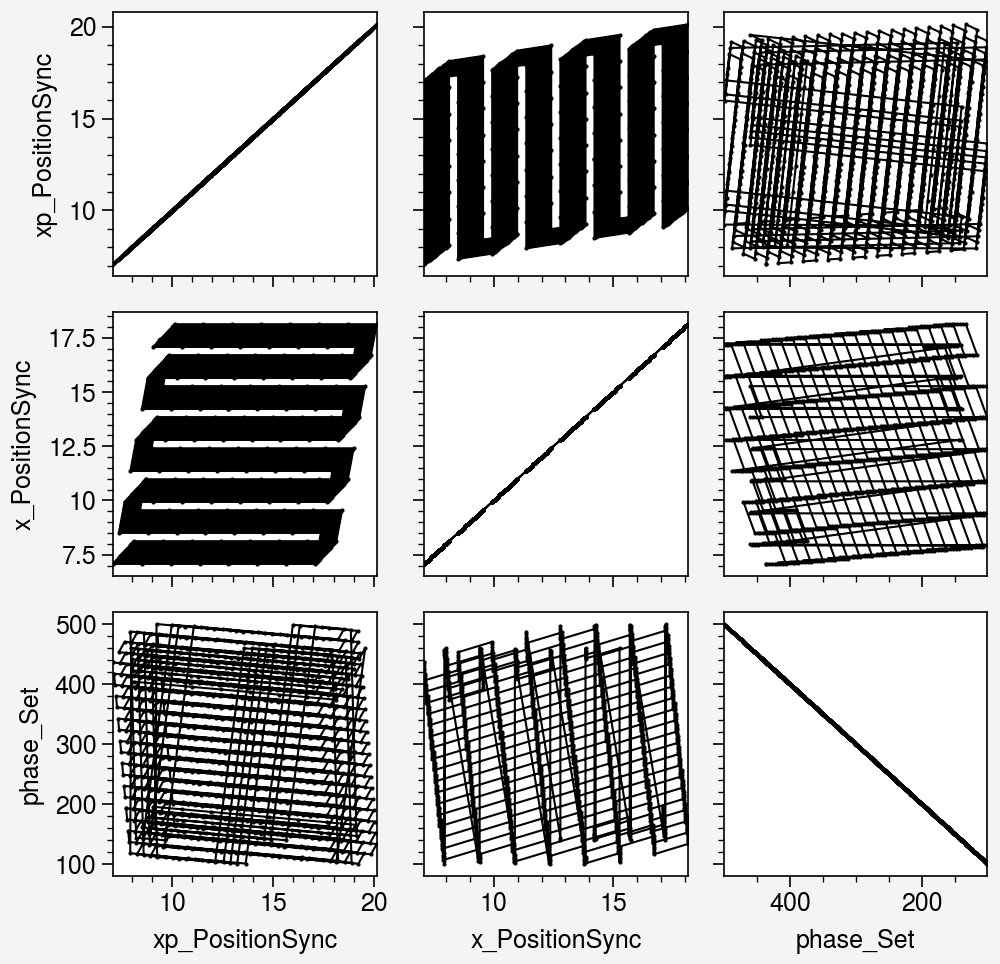

In [59]:
labels = acts
n = len(acts)
fig, axes = pplt.subplots(ncols=n, nrows=n, figwidth=n*(5.0/3.0), span=False)
for i in range(n):
    for j in range(n):
        x = data[acts[j]]
        y = data[acts[i]]
        ax = axes[i, j]
        ax.plot(x, y, marker='.', ms=1, color='black', lw=0.75)
    axes[i, 0].format(ylabel=labels[i])
    axes[-1, i].format(xlabel=labels[i])